In [1]:
!pip install fsspec
!pip install gcsfs
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 12.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 17.3 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 61.7 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 12.7 MB/s 
     |████████████████████████████████| 101 kB 9.7 MB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 
     |████████████████████████████████| 6.6 MB 34.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    TFBertForSequenceClassification,
)

In [4]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud

In [ ]:
#### Código para migrar las labels del dataset original etiquetado al nuevo dataset_2021_paragraph_annotated ####
#### Mejor no ejecutar en COLAB para guardar CSV ####
df_no_labels = pd.read_csv(f"{filepath}.csv", sep=";", index_col=0, parse_dates=["date"])

df_hg = pd.read_csv("tfm/outputs/hg_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_rs = pd.read_csv("tfm/outputs/rs_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_annotated_labels = pd.concat([df_hg,df_rs]).reset_index(drop=True)

old_columns = ["finanzas_news_s_n", "impacto_news_s_n", "topic", "finanzas_s_n", "impacto_s_n"]
new_columns = ["finanzas_tag_news_s_n", "impacto_tag_news_s_n", "topic_tag_news", "finanzas_tag_s_n", "impacto_tag_s_n"]

notna_indexes = df_annotated_labels.loc[:,old_columns].dropna().index
df_annotated_labels = df_annotated_labels.loc[notna_indexes,:]

for idx, row in df_annotated_labels.iterrows():
    for old_label, new_label in zip(old_columns, new_columns):
        df_no_labels.loc[(df_no_labels.body == row.body) & (df_no_labels.title == row.title), new_label] = df_annotated_labels.loc[idx, old_label]

df_no_labels.to_csv(f"{filepath}_annotated.csv", sep=";")
df_total_labels = df_no_labels.copy()

In [5]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", parse_dates=["date"])

In [6]:
tomerge = df_total_labels.drop_duplicates(subset=["pk", "title"]).loc[:,["pk","topic_tag_news"]].dropna()
tomerge

,pk,topic_tag_news
2923,1656289470276_43316_IAG,3.0
5558,1656290550304_43316_BBVA,15.0
5580,1656290550304_43316_BKIA,15.0
5602,1656290550304_43316_CABK,15.0
5624,1656290550304_43316_SAB,15.0
...,...,...
494861,1656407672873_9_BBVA,8.0
494870,1656407672873_9_CABK,8.0
494879,1656407672873_9_SAN,8.0
496364,1656406912310_9_CABK,7.0


In [7]:
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_news_total_no"
labeled_df = pd.read_csv(f"{filepath}_filters.csv", sep=";", parse_dates=["date"], low_memory=False, lineterminator="\n")
labeled_df.shape

(241553, 43)

In [8]:
df = labeled_df.merge(tomerge, how="left", on="pk")

In [9]:
df.dropna(subset=["topic_tag_news"], inplace = True)

In [10]:
topics_equivalence = {
                    1:'Gobierno Corporativo +',
                    2:'Gobierno Corporativo -',
                    3:'Reporte Beneficios +',
                    4:'Reporte Beneficios -',
                    5:'Financiero +',
                    6:'Financiero -',
                    7:'General +',
                    8:'General -',
                    9:'Legal +',
                    10:'Legal -',
                    11:'Operacional +',
                    12:'Operacional -',
                    13:'Restructuración +',
                    14:'Restructuración -'
                    }

In [11]:
df.topic_tag_news = df.topic_tag_news.replace(topics_equivalence)

In [12]:
regrouping_labels = {
                    'Gobierno Corporativo +': 1,
                    'Gobierno Corporativo -': 1,
                    'Reporte Beneficios +': 2,
                    'Reporte Beneficios -': 2,
                    'Financiero +': 3,
                    'Financiero -': 3,
                    'General +':  4,
                    'General -':  4,
                    'Legal +':  5,
                    'Legal -': 5,
                    'Operacional +': 6,
                    'Operacional -': 6,
                    'Restructuración +': 7,
                    'Restructuración -': 7,
                    }

In [13]:
df.topic_tag_news = df.topic_tag_news.replace(regrouping_labels)

In [14]:
df_total_labels = df.copy()

In [15]:
no_doubts_labels = df_total_labels.topic_tag_news[df_total_labels.topic_tag_news < 15].unique()
topic_label = df_total_labels.topic_tag_news.isin(no_doubts_labels)
dataset_labels = df_total_labels[topic_label]
dataset_unlabelled = df_total_labels[~topic_label]

In [16]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [17]:
dataset_labels.topic_tag_news.value_counts()/sum(dataset_labels.topic_tag_news.value_counts())

6.0    0.324841
4.0    0.267516
3.0    0.165605
5.0    0.127389
7.0    0.070064
2.0    0.038217
1.0    0.006369
Name: topic_tag_news, dtype: float64

In [18]:
lb = LabelEncoder()
label = lb.fit_transform(dataset_labels.topic_tag_news)

# Transfer Learning con BETO

A continuación se reentrena la última capa únicamente de FinBERT para la clasificación de los topics del dataset de noticias.

In [19]:
N_LABELS = len(np.unique(dataset_labels.topic_tag_news))

In [20]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [21]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

Downloading:   0%|          | 0.00/512M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model.layers[0].trainable=False

In [23]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, label, test_size=0.2, random_state=42)

In [25]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [26]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [27]:
N_EPOCAS = 150

In [42]:
# filepath_checkpoint = './checkpoints/topic_tag_news_regroup/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/topic_tag_news_regroup/checkpoint' # Filepath COLAB

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
1/1 [==============================] - 22s 22s/step - loss: 1.9610 - accuracy: 0.0625 - val_loss: 1.9174 - val_accuracy: 0.1538
Epoch 2/150
1/1 [==============================] - 3s 3s/step - loss: 1.9484 - accuracy: 0.1071 - val_loss: 1.9066 - val_accuracy: 0.1538
Epoch 3/150
1/1 [==============================] - 3s 3s/step - loss: 1.9345 - accuracy: 0.1339 - val_loss: 1.8961 - val_accuracy: 0.1538
Epoch 4/150
1/1 [==============================] - 3s 3s/step - loss: 1.9243 - accuracy: 0.1875 - val_loss: 1.8858 - val_accuracy: 0.1538
Epoch 5/150
1/1 [==============================] - 3s 3s/step - loss: 1.9127 - accuracy: 0.1964 - val_loss: 1.8757 - val_accuracy: 0.1538
Epoch 6/150
1/1 [==============================] - 4s 4s/step - loss: 1.8944 - accuracy: 0.2768 - val_loss: 1.8659 - val_accuracy: 0.2308
Epoch 7/150
1/1 [==============================] - 3s 3s/step - loss: 1.8944 - accuracy: 0.2857 - val_loss: 1.8562 - val_accuracy: 0.2308
Epoch 8/150
1/1 [===============

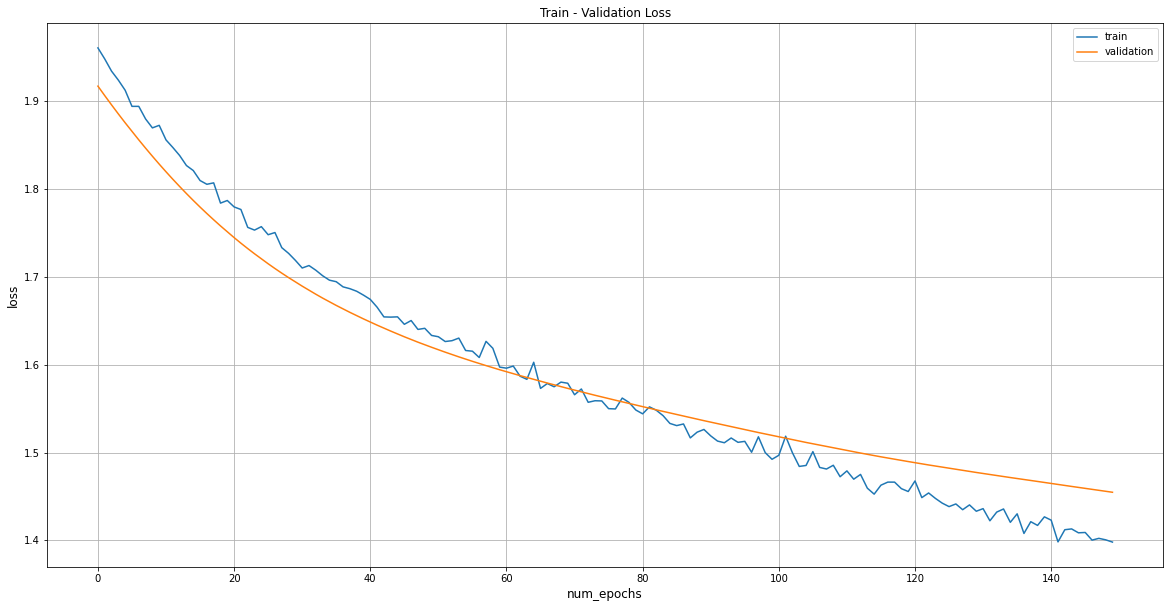

In [43]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

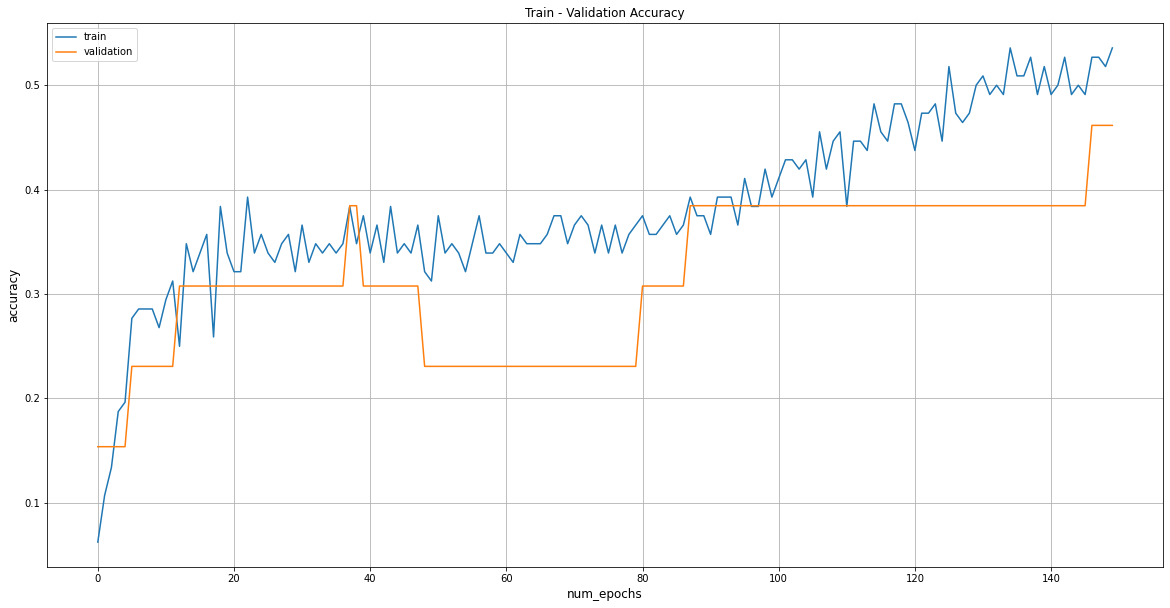

In [44]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [45]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

1/1 [==============================] - 2s 2s/step - loss: 1.3287 - accuracy: 0.5312


[1.3287427425384521, 0.53125]

In [46]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

5    0.312
3    0.248
2    0.176
4    0.128
6    0.080
1    0.048
0    0.008
dtype: float64

In [47]:
y_pred = model.predict(x_test.data)

In [48]:
y_pred = y_pred.logits.argmax(axis=1)

In [49]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           2       0.50      0.25      0.33         4
           3       0.80      0.36      0.50        11
           4       0.50      0.25      0.33         4
           5       0.48      0.92      0.63        12
           6       0.00      0.00      0.00         1

    accuracy                           0.53        32
   macro avg       0.46      0.36      0.36        32
weighted avg       0.58      0.53      0.49        32



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


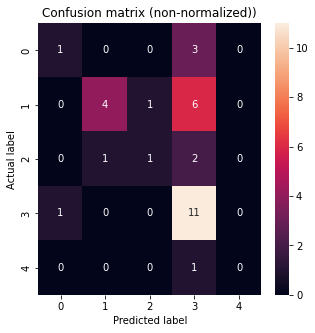

In [50]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [51]:
def func_apply(row):
    if (not type(row.body_no_entities)==str):    
        row.body_no_entities = str(row.body_no_entities)
    x = tokenizer(row.body_no_entities, padding="max_length", truncation=True, return_tensors="tf")
    y_pred = model.predict(x.data)
    row['topic_tag_news'] = int(lb.inverse_transform(y_pred.logits.argmax(axis=1))[0])
    row['topic_tag_news_proba'] = tf.nn.softmax(y_pred.logits).numpy().max(axis=1)[0]
    return row

In [52]:
tqdm.pandas()
df_total_labels["topic_tag_news_proba"] = np.NaN
df_total_labels.loc[topic_label, "topic_tag_news_proba"] = 1.
df_total_labels.loc[~topic_label] = df_total_labels.loc[~topic_label].progress_apply(lambda row : func_apply(row), axis=1)

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
# df_total_labels.to_csv(f'{filepath}_predict_topic_tag_news.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/100
4/4 [==============================] - 29s 3s/step - loss: 1.8647 - accuracy: 0.2381 - val_loss: 1.8506 - val_accuracy: 0.2667
Epoch 2/100
4/4 [==============================] - 4s 962ms/step - loss: 1.8465 - accuracy: 0.2063 - val_loss: 1.8178 - val_accuracy: 0.2000
Epoch 3/100
4/4 [==============================] - 4s 960ms/step - loss: 1.8050 - accuracy: 0.3016 - val_loss: 1.7882 - val_accuracy: 0.2000
Epoch 4/100
4/4 [==============================] - 4s 962ms/step - loss: 1.7838 - accuracy: 0.3254 - val_loss: 1.7620 - val_accuracy: 0.2000
Epoch 5/100
4/4 [==============================] - 4s 964ms/step - loss: 1.7682 - accuracy: 0.3016 - val_loss: 1.7380 - val_accuracy: 0.2000
Epoch 6/100
4/4 [==============================] - 4s 961ms/step - loss: 1.7430 - accuracy: 0.3095 - val_loss: 1.7172 - val_accuracy: 0.2000
Epoch 7/100
4/4 [==============================] - 4s 961ms/step - loss: 1.7318 - accuracy: 0.3413 - val_loss: 1.6984 - val_accuracy

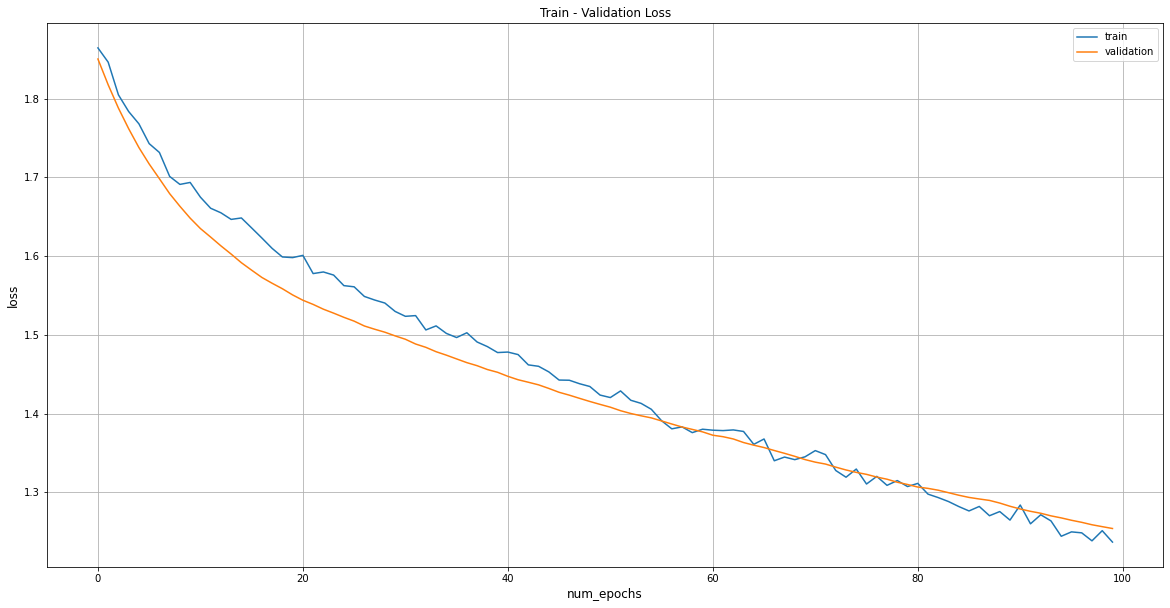

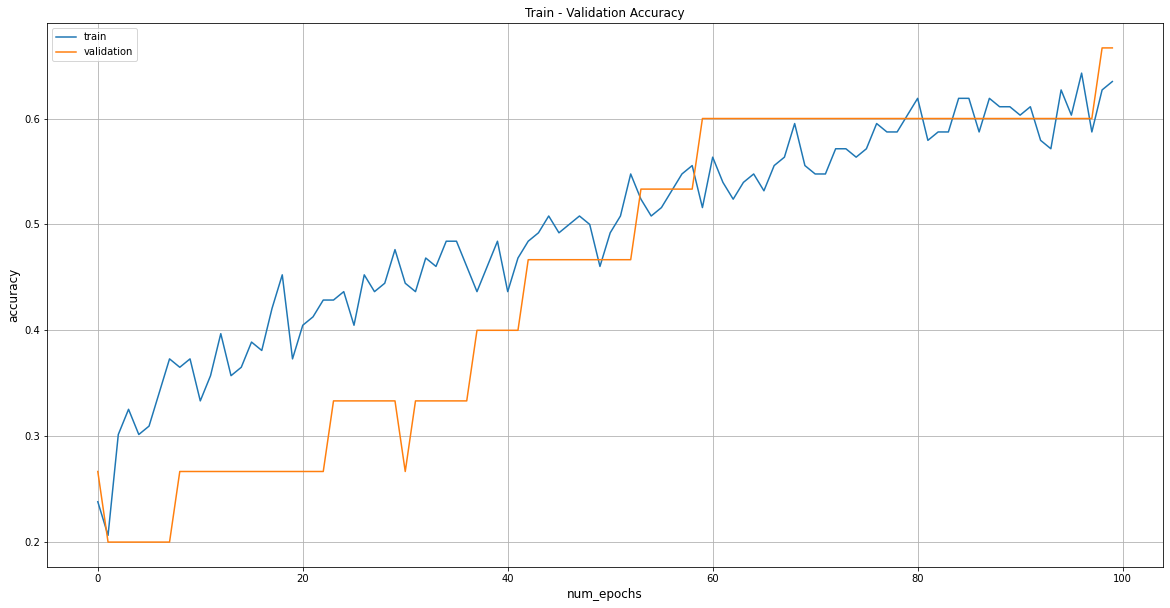

1/1 [==============================] - 0s 411ms/step - loss: 1.1691 - accuracy: 0.5625
Accuracy: 0.5625


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9139 - accuracy: 0.2302 - val_loss: 1.8883 - val_accuracy: 0.2667
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 1.8730 - accuracy: 0.2937 - val_loss: 1.8476 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8505 - accuracy: 0.3333 - val_loss: 1.8094 - val_accuracy: 0.3333
Epoch 4/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8156 - accuracy: 0.3571 - val_loss: 1.7753 - val_accuracy: 0.3333
Epoch 5/100
4/4 [==============================] - 4s 963ms/step - loss: 1.7954 - accuracy: 0.3095 - val_loss: 1.7443 - val_accuracy: 0.3333
Epoch 6/100
4/4 [==============================] - 4s 960ms/step - loss: 1.7580 - accuracy: 0.3333 - val_loss: 1.7161 - val_accuracy: 0.3333
Epoch 7/100
4/4 [==============================] - 4s 960ms/step - loss: 1.7343 - accuracy: 0.3492 - val_loss: 1.6907 - val_accuracy: 0

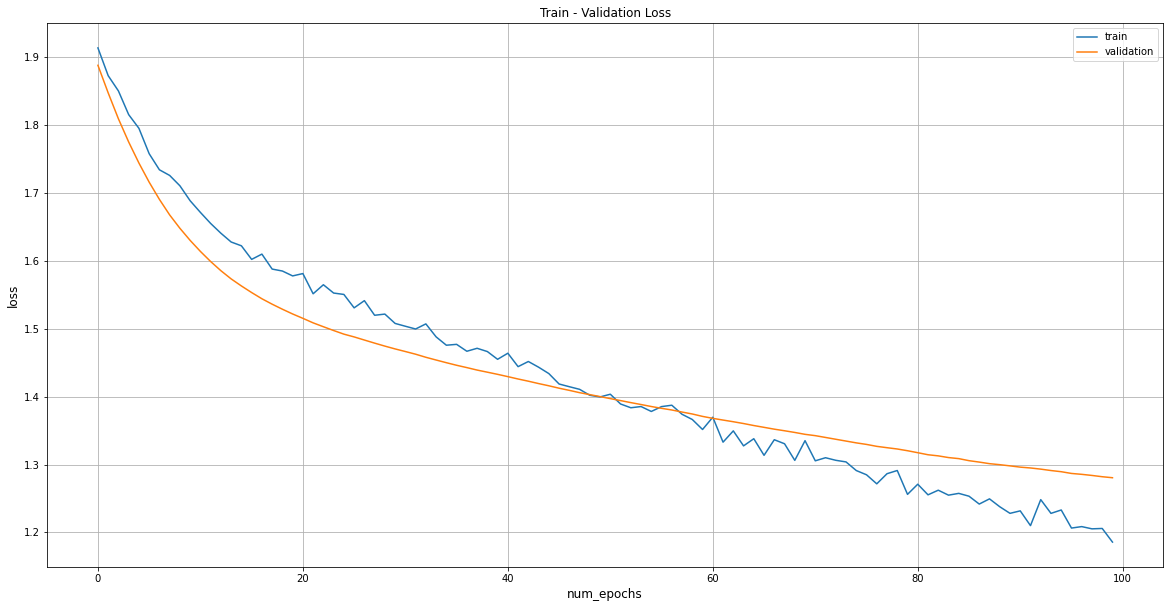

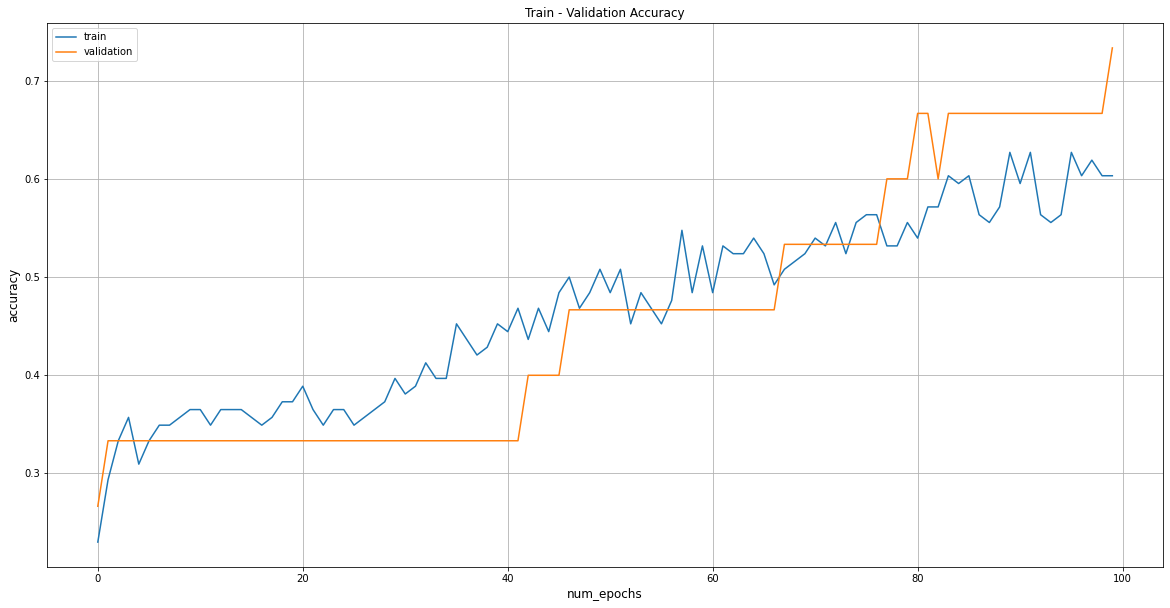

1/1 [==============================] - 0s 422ms/step - loss: 1.3654 - accuracy: 0.3750
Accuracy: 0.375


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 2.0216 - accuracy: 0.0714 - val_loss: 2.0106 - val_accuracy: 0.0667
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 1.9654 - accuracy: 0.1349 - val_loss: 1.9637 - val_accuracy: 0.2000
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 1.9424 - accuracy: 0.2143 - val_loss: 1.9201 - val_accuracy: 0.2667
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 1.9036 - accuracy: 0.2778 - val_loss: 1.8797 - val_accuracy: 0.3333
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 1.8681 - accuracy: 0.3175 - val_loss: 1.8422 - val_accuracy: 0.4000
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 1.8269 - accuracy: 0.3175 - val_loss: 1.8082 - val_accuracy: 0.5333
Epoch 7/100
4/4 [==============================] - 4s 961ms/step - loss: 1.7903 - accuracy: 0.3889 - val_loss: 1.7771 - val_accuracy: 0.5333
Epoch 

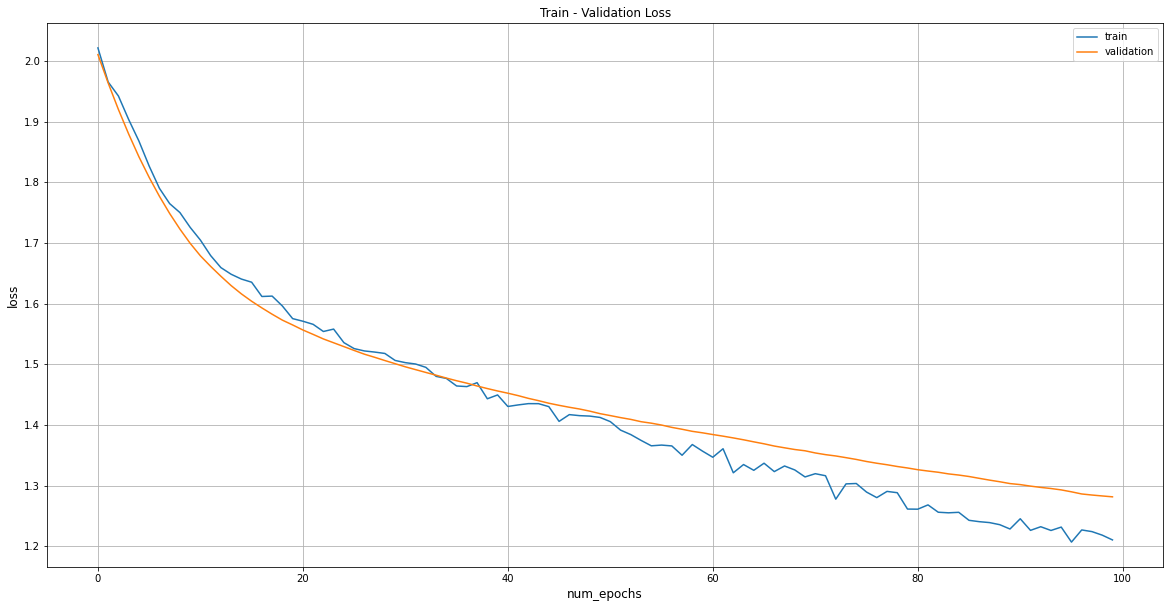

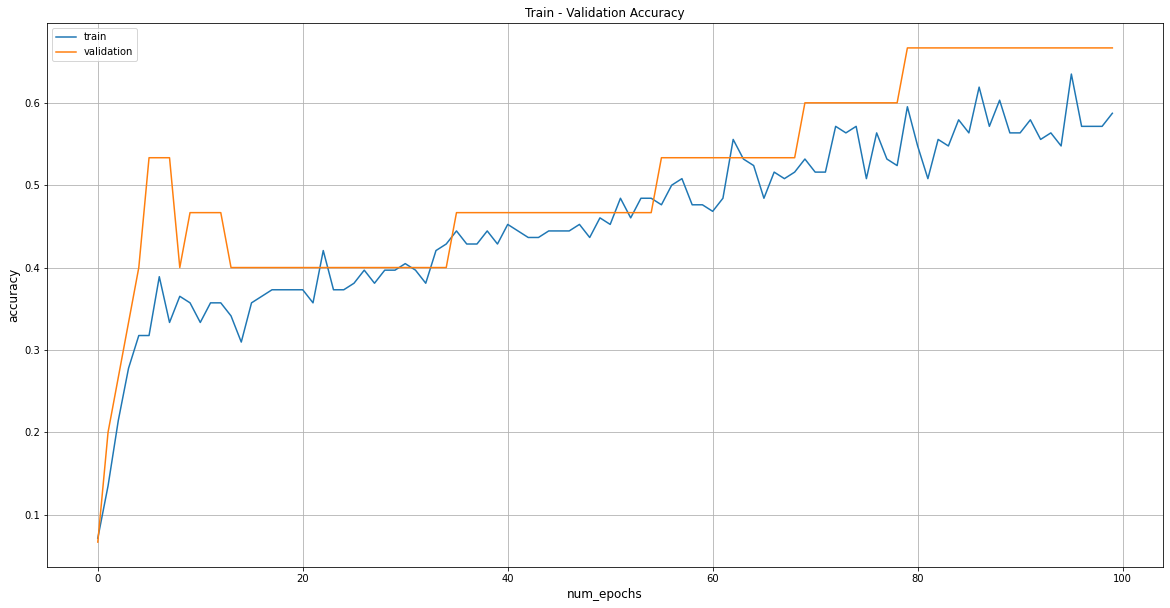

1/1 [==============================] - 0s 414ms/step - loss: 1.5100 - accuracy: 0.4375
Accuracy: 0.4375


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9676 - accuracy: 0.1349 - val_loss: 1.9574 - val_accuracy: 0.0667
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 1.9196 - accuracy: 0.2063 - val_loss: 1.9090 - val_accuracy: 0.1333
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 1.8802 - accuracy: 0.2619 - val_loss: 1.8639 - val_accuracy: 0.2000
Epoch 4/100
4/4 [==============================] - 5s 2s/step - loss: 1.8416 - accuracy: 0.3095 - val_loss: 1.8229 - val_accuracy: 0.4000
Epoch 5/100
4/4 [==============================] - 4s 960ms/step - loss: 1.8036 - accuracy: 0.3571 - val_loss: 1.7873 - val_accuracy: 0.4000
Epoch 6/100
4/4 [==============================] - 4s 961ms/step - loss: 1.7622 - accuracy: 0.3413 - val_loss: 1.7551 - val_accuracy: 0.4000
Epoch 7/100
4/4 [==============================] - 4s 961ms/step - loss: 1.7310 - accuracy: 0.3492 - val_loss: 1.7249 - val_accuracy: 0.4000


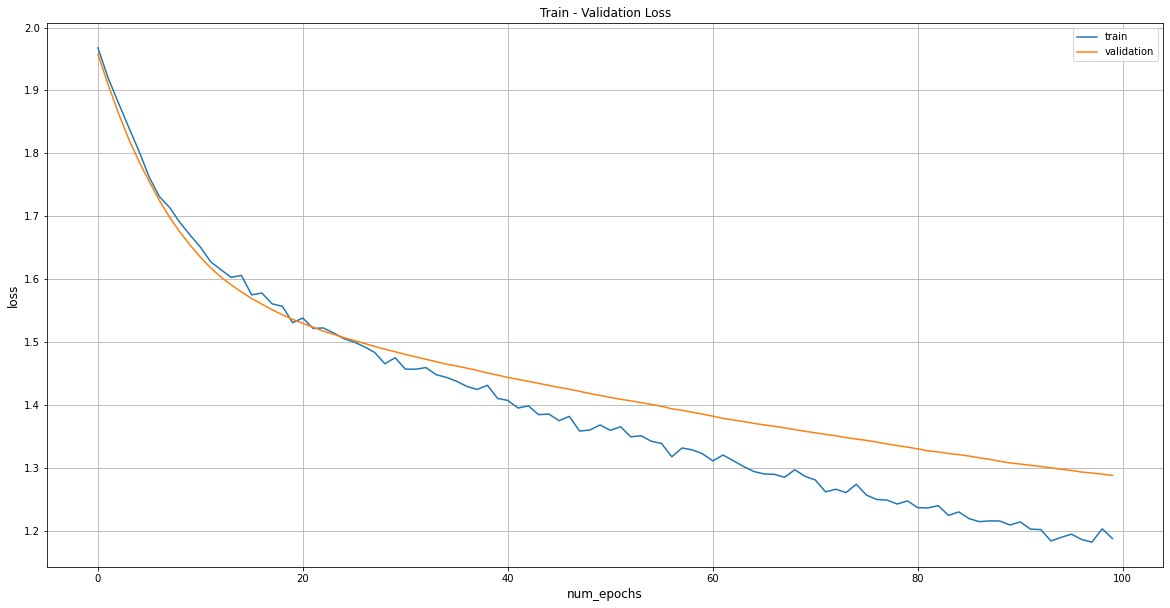

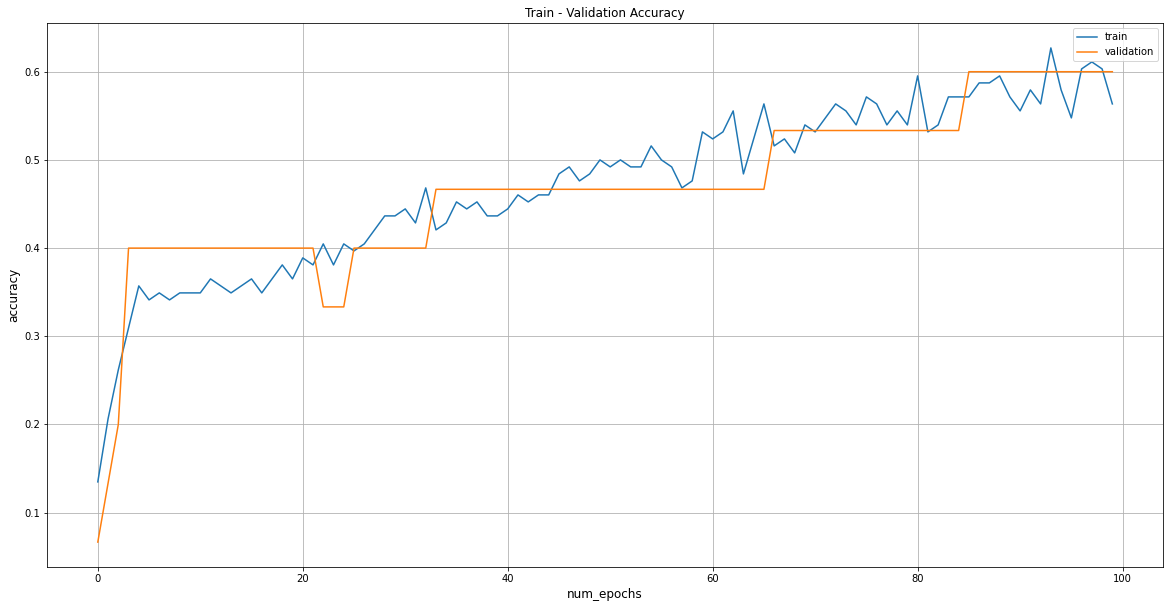

1/1 [==============================] - 0s 414ms/step - loss: 1.8107 - accuracy: 0.2500
Accuracy: 0.25


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9733 - accuracy: 0.1746 - val_loss: 1.9539 - val_accuracy: 0.1333
Epoch 2/100
4/4 [==============================] - 5s 2s/step - loss: 1.9280 - accuracy: 0.2143 - val_loss: 1.9064 - val_accuracy: 0.2000
Epoch 3/100
4/4 [==============================] - 4s 962ms/step - loss: 1.8886 - accuracy: 0.2460 - val_loss: 1.8632 - val_accuracy: 0.2000
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 1.8616 - accuracy: 0.2460 - val_loss: 1.8231 - val_accuracy: 0.2667
Epoch 5/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8225 - accuracy: 0.2698 - val_loss: 1.7859 - val_accuracy: 0.2667
Epoch 6/100
4/4 [==============================] - 4s 962ms/step - loss: 1.7948 - accuracy: 0.2778 - val_loss: 1.7516 - val_accuracy: 0.2667
Epoch 7/100
4/4 [==============================] - 4s 962ms/step - loss: 1.7655 - accuracy: 0.2937 - val_loss: 1.7204 - val_accuracy: 0.26

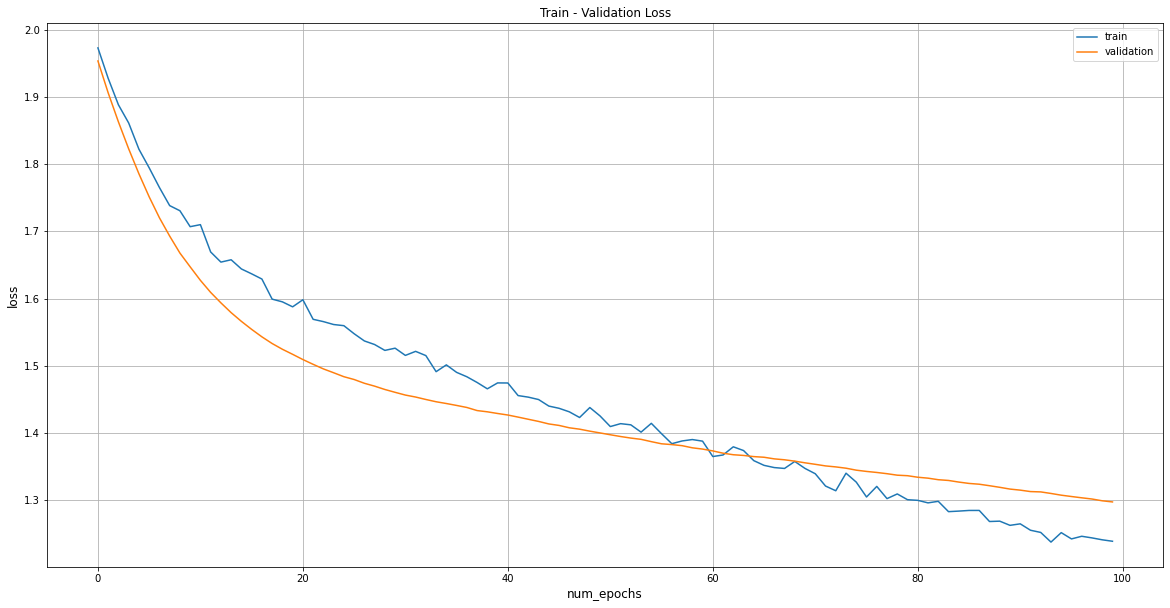

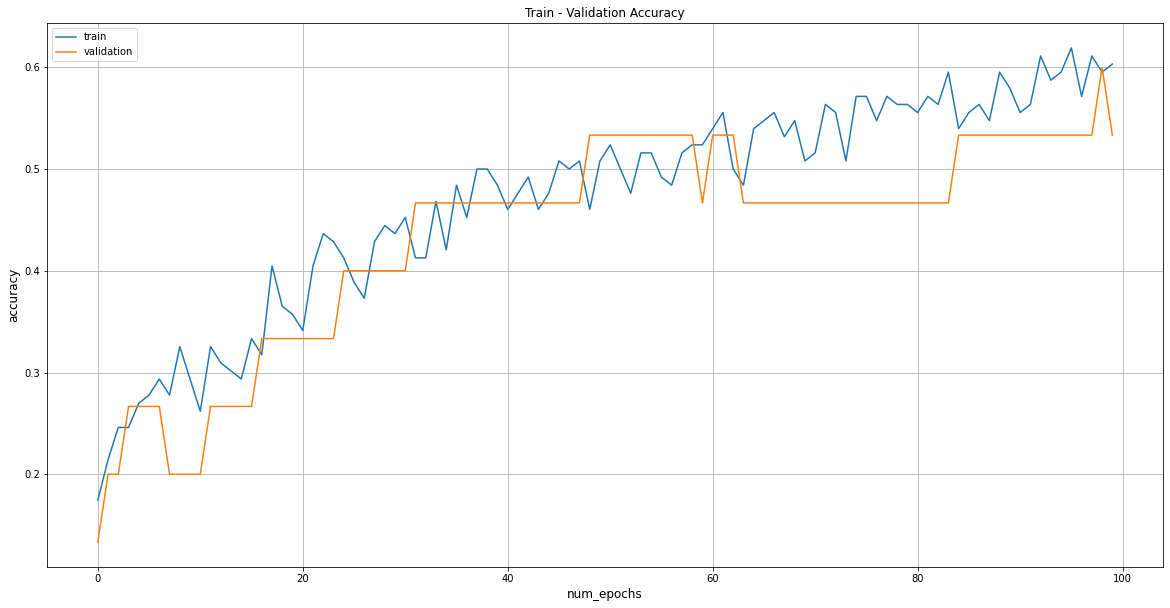

1/1 [==============================] - 0s 414ms/step - loss: 1.3966 - accuracy: 0.6250
Accuracy: 0.625


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9785 - accuracy: 0.1032 - val_loss: 1.9432 - val_accuracy: 0.1333
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 1.9593 - accuracy: 0.1349 - val_loss: 1.8912 - val_accuracy: 0.2667
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 1.9087 - accuracy: 0.2222 - val_loss: 1.8434 - val_accuracy: 0.3333
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 1.8824 - accuracy: 0.2619 - val_loss: 1.7992 - val_accuracy: 0.4000
Epoch 5/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8258 - accuracy: 0.3333 - val_loss: 1.7603 - val_accuracy: 0.4000
Epoch 6/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8116 - accuracy: 0.3175 - val_loss: 1.7239 - val_accuracy: 0.4000
Epoch 7/100
4/4 [==============================] - 4s 960ms/step - loss: 1.8025 - accuracy: 0.3333 - val_loss: 1.6904 - val_accuracy: 0.4000


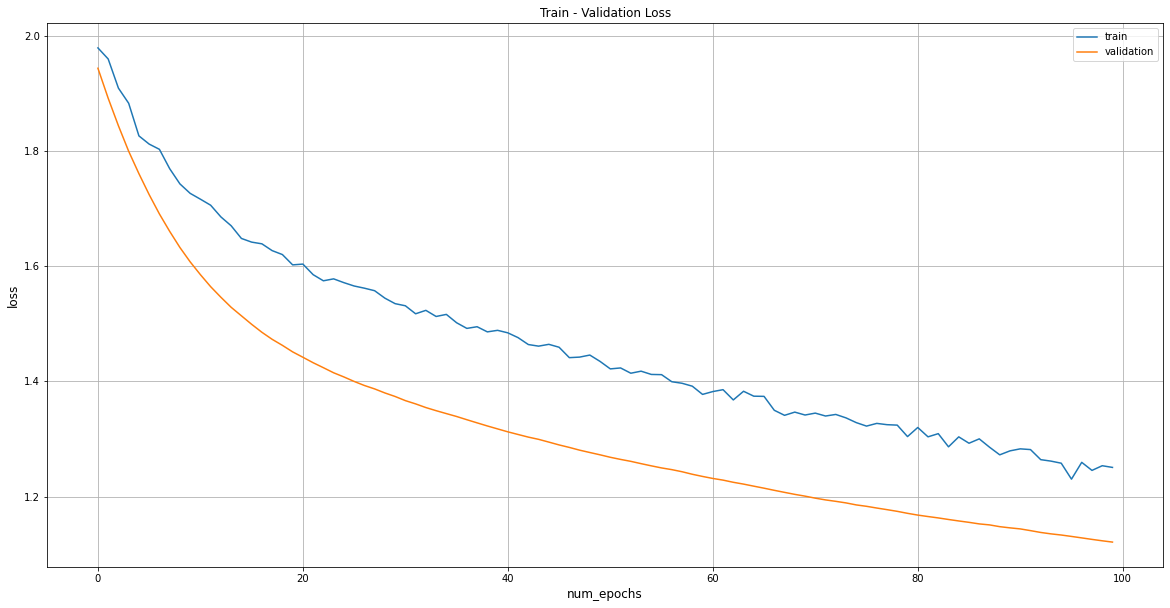

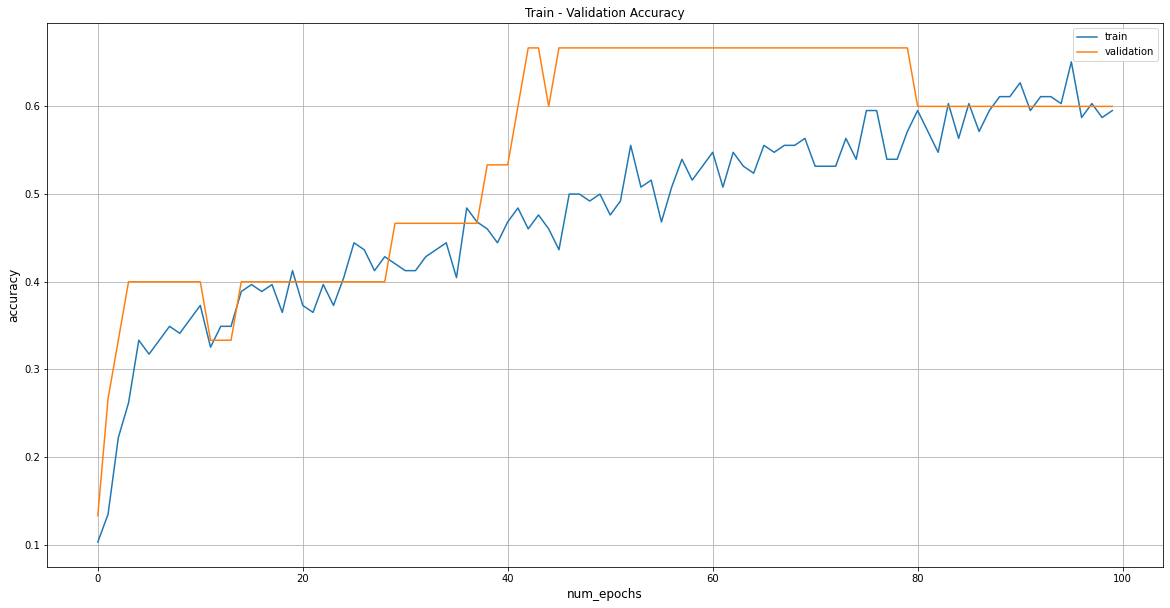

1/1 [==============================] - 0s 415ms/step - loss: 1.4920 - accuracy: 0.4375
Accuracy: 0.4375


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9478 - accuracy: 0.1667 - val_loss: 1.9284 - val_accuracy: 0.2000
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 1.9243 - accuracy: 0.1984 - val_loss: 1.8902 - val_accuracy: 0.2667
Epoch 3/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8879 - accuracy: 0.3175 - val_loss: 1.8531 - val_accuracy: 0.2667
Epoch 4/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8523 - accuracy: 0.2937 - val_loss: 1.8188 - val_accuracy: 0.2000
Epoch 5/100
4/4 [==============================] - 4s 961ms/step - loss: 1.8215 - accuracy: 0.2937 - val_loss: 1.7880 - val_accuracy: 0.2000
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 1.7887 - accuracy: 0.3730 - val_loss: 1.7594 - val_accuracy: 0.3333
Epoch 7/100
4/4 [==============================] - 4s 961ms/step - loss: 1.7800 - accuracy: 0.3016 - val_loss: 1.7339 - val_accuracy: 0.33

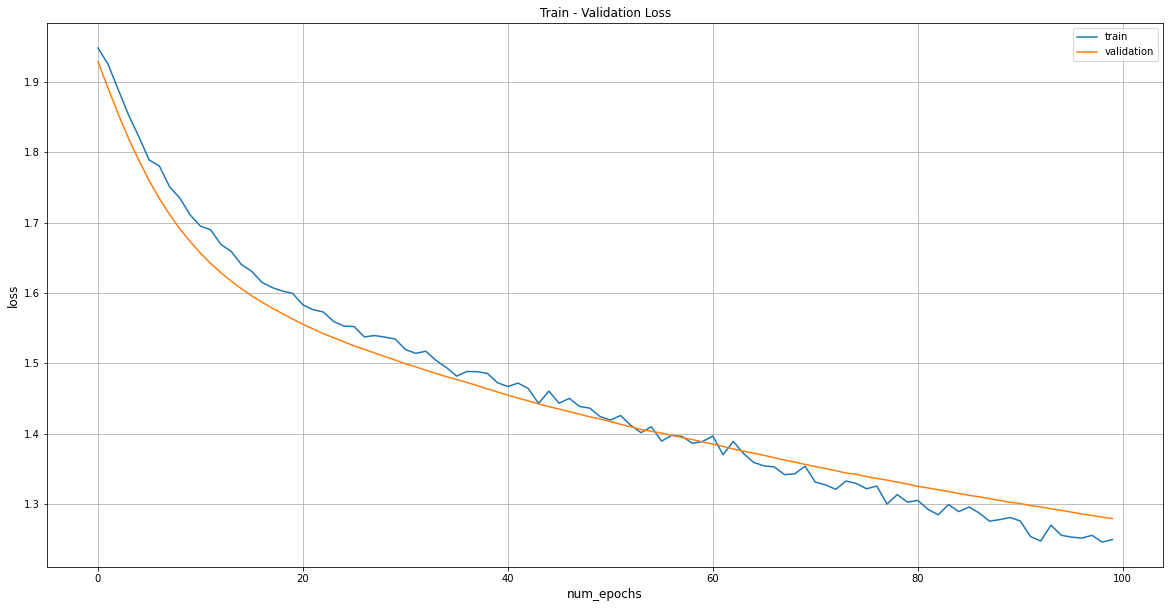

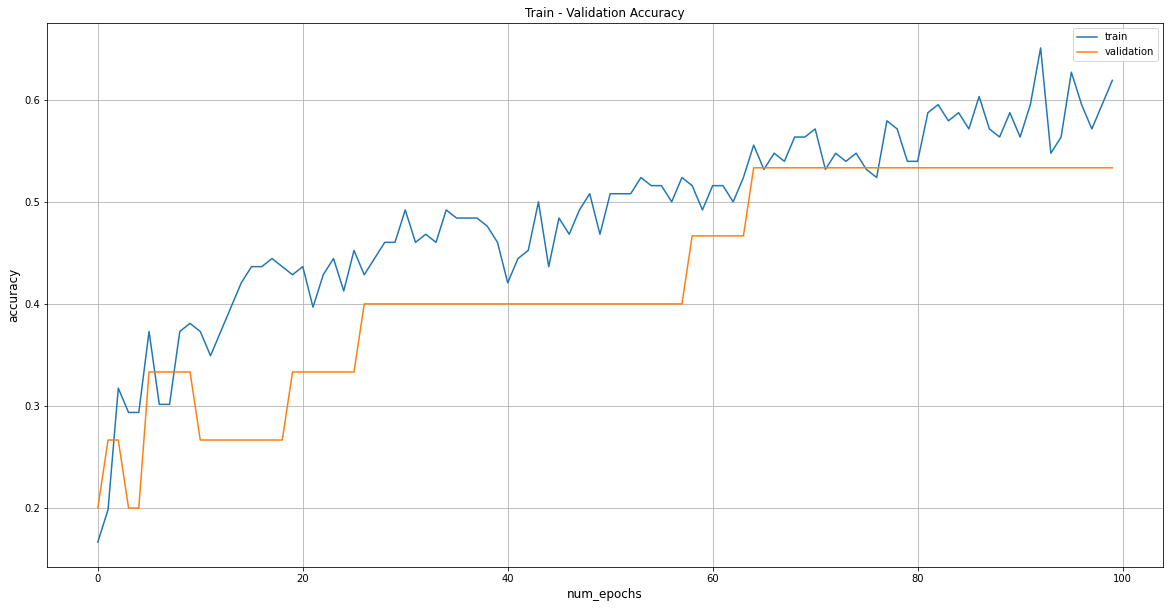

1/1 [==============================] - 0s 415ms/step - loss: 1.3396 - accuracy: 0.5625
Accuracy: 0.5625


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9541 - accuracy: 0.1811 - val_loss: 1.9334 - val_accuracy: 0.3333
Epoch 2/100
4/4 [==============================] - 4s 967ms/step - loss: 1.9347 - accuracy: 0.2205 - val_loss: 1.8813 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 1.8877 - accuracy: 0.2835 - val_loss: 1.8368 - val_accuracy: 0.4000
Epoch 4/100
4/4 [==============================] - 5s 2s/step - loss: 1.8524 - accuracy: 0.2835 - val_loss: 1.7963 - val_accuracy: 0.4667
Epoch 5/100
4/4 [==============================] - 4s 972ms/step - loss: 1.8198 - accuracy: 0.3150 - val_loss: 1.7582 - val_accuracy: 0.4667
Epoch 6/100
4/4 [==============================] - 4s 969ms/step - loss: 1.8017 - accuracy: 0.3071 - val_loss: 1.7255 - val_accuracy: 0.4667
Epoch 7/100
4/4 [==============================] - 4s 969ms/step - loss: 1.7753 - accuracy: 0.2992 - val_loss: 1.6964 - val_accuracy: 0.46

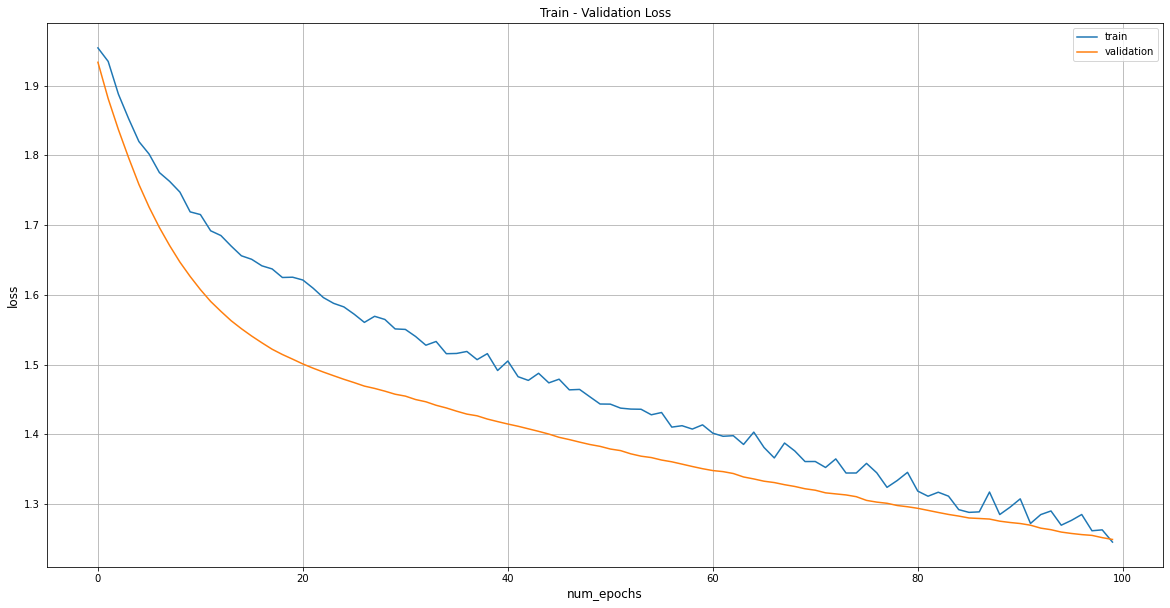

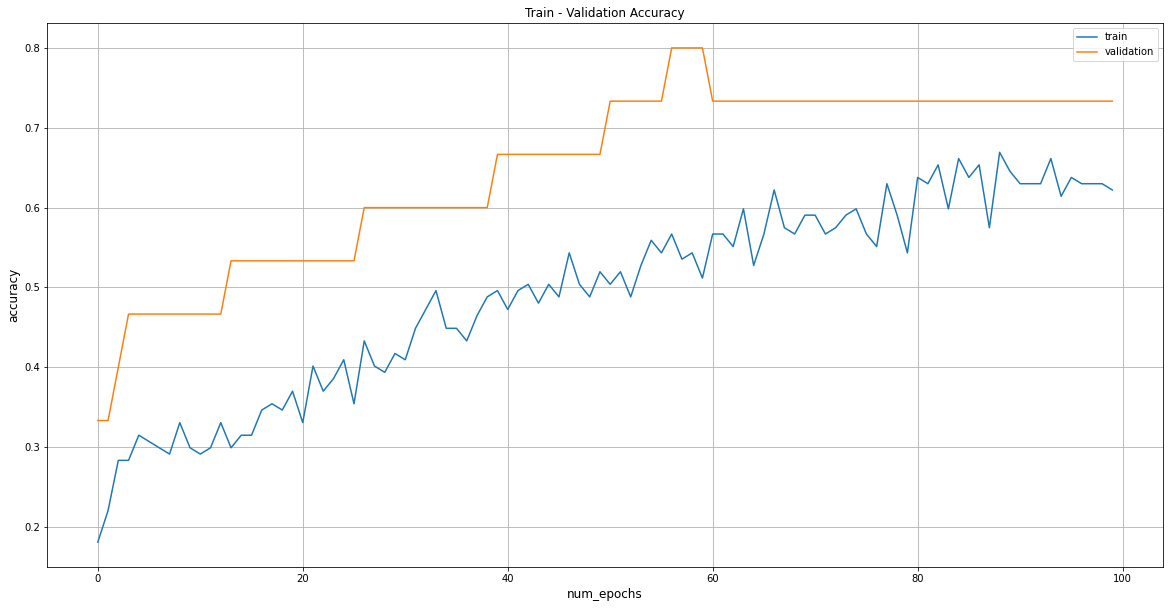

1/1 [==============================] - 0s 392ms/step - loss: 1.1706 - accuracy: 0.6667
Accuracy: 0.6666666865348816


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9772 - accuracy: 0.0630 - val_loss: 1.9347 - val_accuracy: 0.2000
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 1.9345 - accuracy: 0.1417 - val_loss: 1.8837 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 1.8974 - accuracy: 0.2677 - val_loss: 1.8360 - val_accuracy: 0.4667
Epoch 4/100
4/4 [==============================] - 4s 967ms/step - loss: 1.8582 - accuracy: 0.3228 - val_loss: 1.7912 - val_accuracy: 0.4667
Epoch 5/100
4/4 [==============================] - 4s 968ms/step - loss: 1.8239 - accuracy: 0.3937 - val_loss: 1.7498 - val_accuracy: 0.4667
Epoch 6/100
4/4 [==============================] - 4s 970ms/step - loss: 1.7964 - accuracy: 0.4331 - val_loss: 1.7115 - val_accuracy: 0.4667
Epoch 7/100
4/4 [==============================] - 4s 968ms/step - loss: 1.7664 - accuracy: 0.3622 - val_loss: 1.6777 - val_accuracy: 0.40

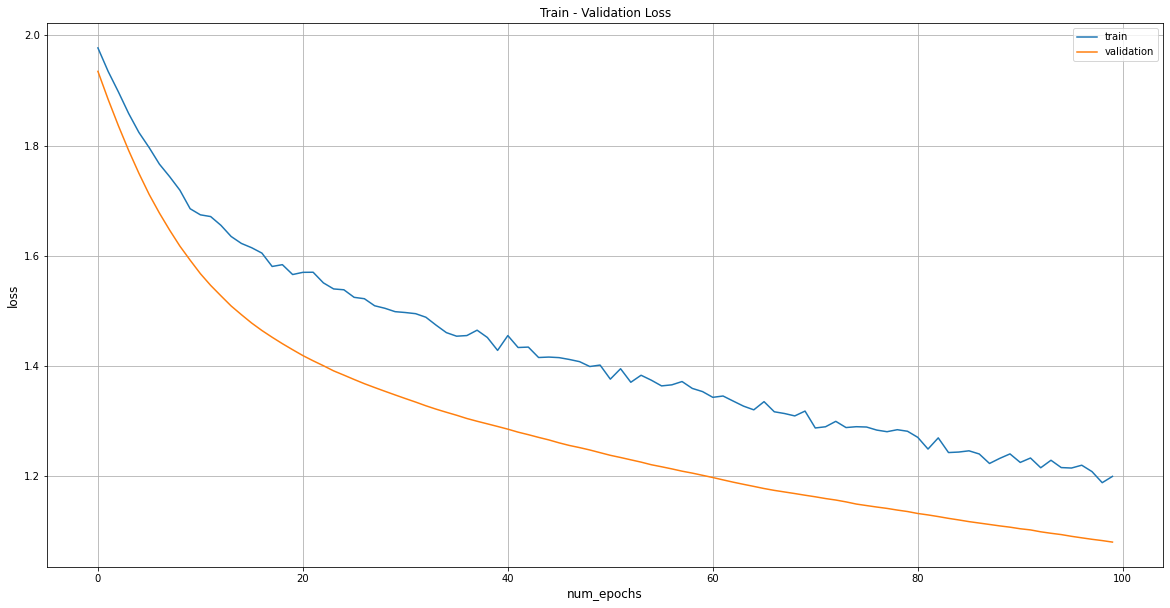

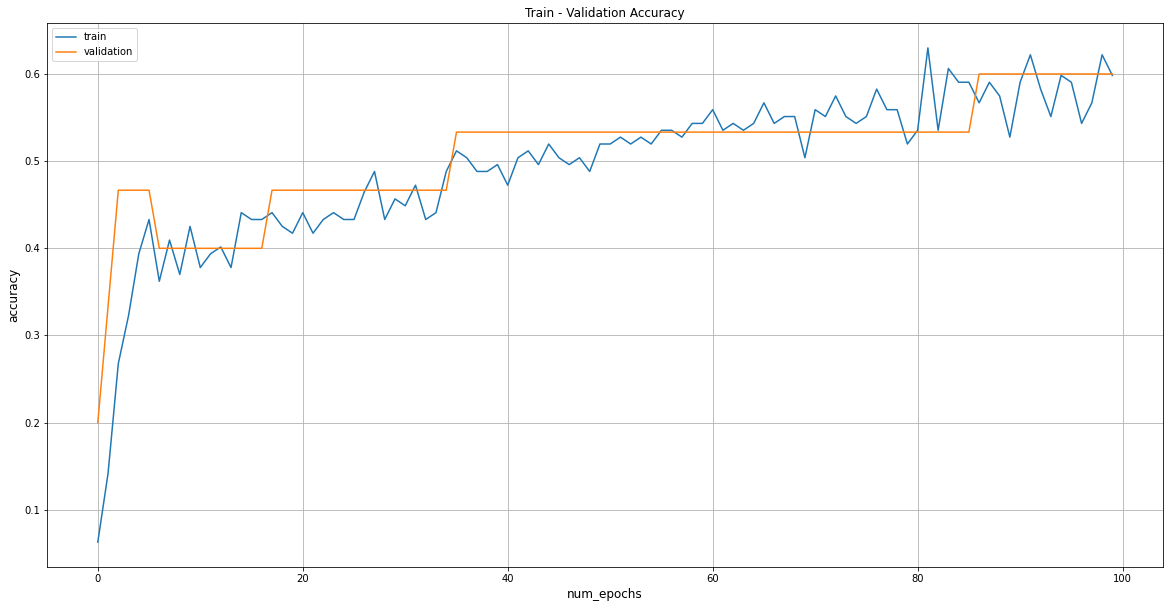

1/1 [==============================] - 0s 392ms/step - loss: 1.6487 - accuracy: 0.1333
Accuracy: 0.13333334028720856


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/100
4/4 [==============================] - 25s 3s/step - loss: 1.9819 - accuracy: 0.0787 - val_loss: 1.9244 - val_accuracy: 0.2667
Epoch 2/100
4/4 [==============================] - 4s 967ms/step - loss: 1.9302 - accuracy: 0.2441 - val_loss: 1.8820 - val_accuracy: 0.2667
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 1.9133 - accuracy: 0.2520 - val_loss: 1.8430 - val_accuracy: 0.4000
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 1.8774 - accuracy: 0.2205 - val_loss: 1.8072 - val_accuracy: 0.5333
Epoch 5/100
4/4 [==============================] - 4s 969ms/step - loss: 1.8438 - accuracy: 0.2992 - val_loss: 1.7746 - val_accuracy: 0.4667
Epoch 6/100
4/4 [==============================] - 4s 968ms/step - loss: 1.8114 - accuracy: 0.3386 - val_loss: 1.7448 - val_accuracy: 0.4667
Epoch 7/100
4/4 [==============================] - 4s 968ms/step - loss: 1.7726 - accuracy: 0.3701 - val_loss: 1.7179 - val_accuracy: 0.4

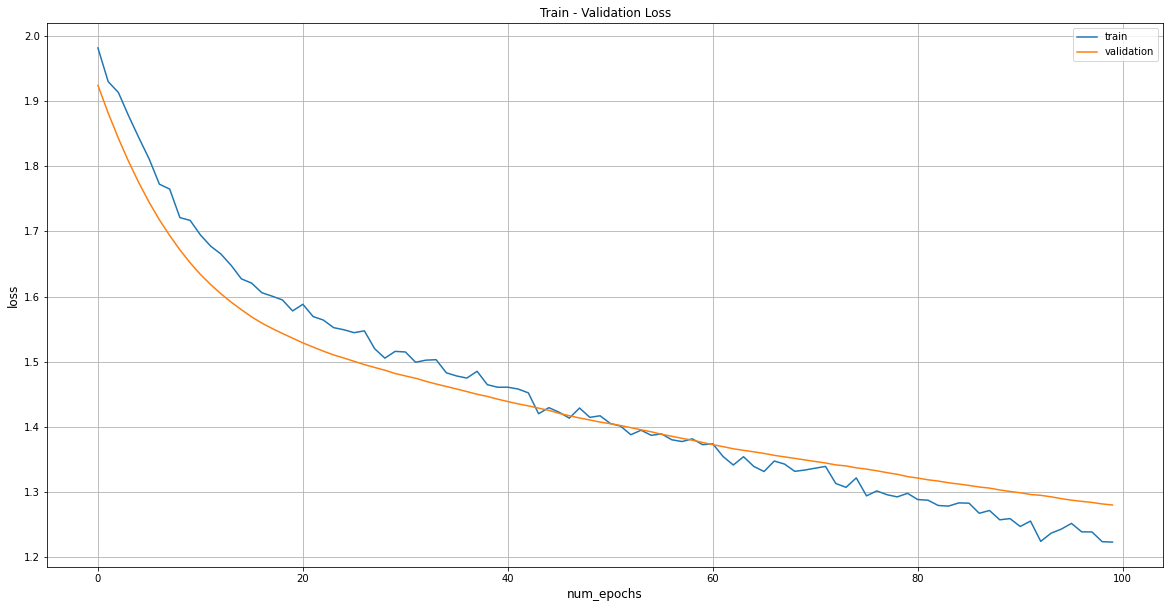

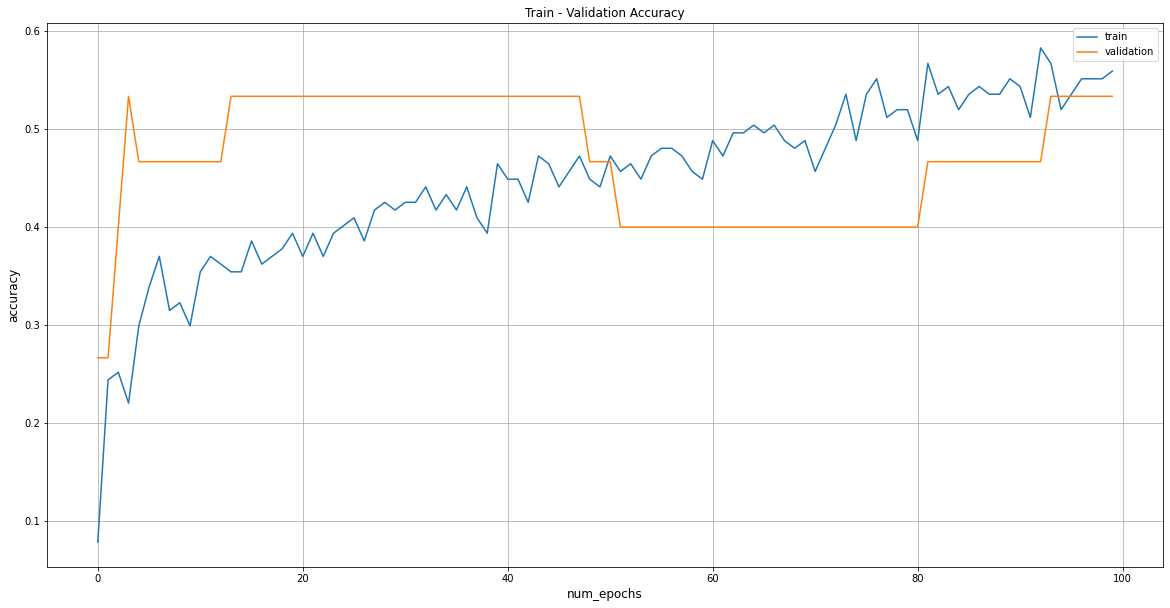

1/1 [==============================] - 0s 393ms/step - loss: 1.8772 - accuracy: 0.2000
Accuracy: 0.20000000298023224


accuracy    0.425
dtype: float64

In [28]:
N_EPOCAS = 100
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/topic_tag_news_regroup/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = label[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = label[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [29]:
result

,accuracy
0,0.562500
1,0.375000
2,0.437500
3,0.250000
4,0.625000
5,0.437500
6,0.562500
7,0.666667
8,0.133333
9,0.200000


In [30]:
result.mean()

accuracy    0.425
dtype: float64